## __Voting Classifier__

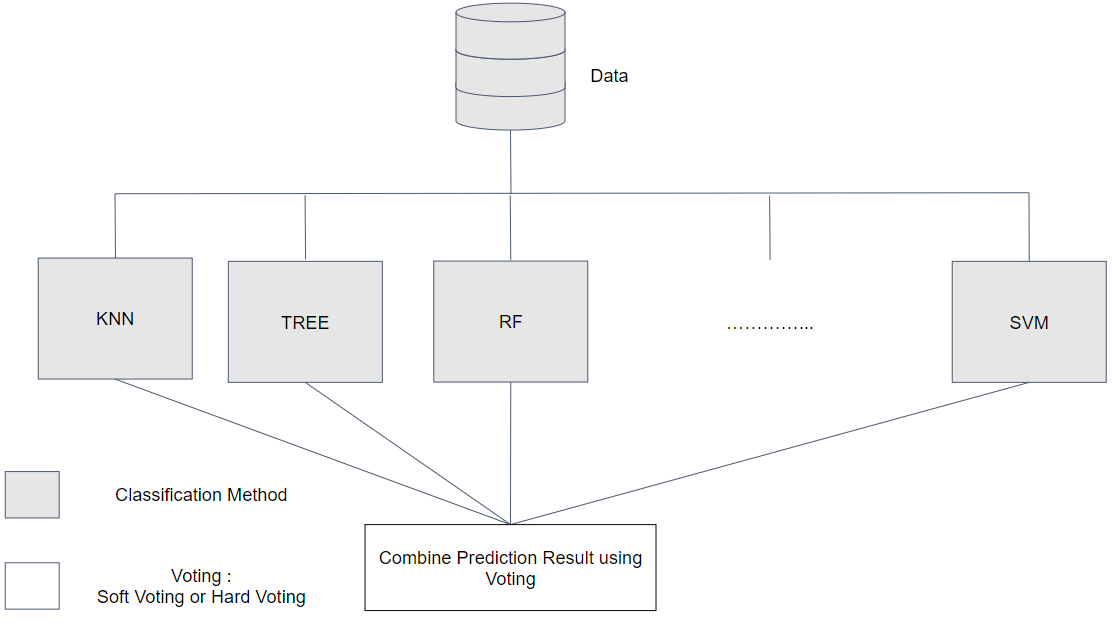

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
wine = pd.read_csv('white_wine.csv')

In [3]:
wine['alcohol'].fillna(wine['alcohol'].mean(), inplace=True) # data leakage
wine['label'] = np.where(wine['quality']>6, 1, 0)
X = wine[['alcohol', 'density']]
y = wine['label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=2020)

In [5]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier(n_neighbors = 3)

In [6]:
for clfs, clf_name in zip([lr, dtc, knn], ['Logistic Regression', 'Decision Tree Classifier', 'K-Nearest Neighbors']):
    clfs.fit(X_train, y_train)
    y_pred = clfs.predict(X_test)
    print(clf_name+':')
    print(classification_report(y_test, y_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        84
           1       0.75      0.45      0.56        20

    accuracy                           0.87       104
   macro avg       0.82      0.71      0.74       104
weighted avg       0.86      0.87      0.85       104

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.75      0.75      0.75        20

    accuracy                           0.90       104
   macro avg       0.85      0.85      0.85       104
weight

In [7]:
vc = VotingClassifier([('clf2', dtc), ('clf3', knn)], voting='soft')

In [8]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('clf2', DecisionTreeClassifier(max_depth=5)),
                             ('clf3', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

In [9]:
y_pred = vc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        84
           1       1.00      0.85      0.92        20

    accuracy                           0.97       104
   macro avg       0.98      0.93      0.95       104
weighted avg       0.97      0.97      0.97       104



> ## Modelling Improvement

In [12]:
lr = LogisticRegression(solver='liblinear', C=0.01)
lr_poly = PolynomialFeatures(degree=3, include_bias=False)

pipe_lr = Pipeline([
            ('poly', lr_poly),
            ('clf', lr)
])


dt = DecisionTreeClassifier(max_depth = 5, min_samples_split=10)
knn = KNeighborsClassifier(n_neighbors = 3)

pipe_knn = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', knn)
])

In [13]:
for clfs, clf_name in zip([pipe_lr, dtc, pipe_knn], ['Logistic Regression', 'Decision Tree Classifier', 'K-Nearest Neighbors']):
    clfs.fit(X_train, y_train)
    y_pred = clfs.predict(X_test)
    print(clf_name+':')
    print(classification_report(y_test, y_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        84
           1       0.75      0.45      0.56        20

    accuracy                           0.87       104
   macro avg       0.82      0.71      0.74       104
weighted avg       0.86      0.87      0.85       104

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.95      0.95      0.95        20

    accuracy                           0.98       104
   macro avg       0.97      0.97      0.97       104
weight

In [14]:
vc_improve = VotingClassifier([
    ('clf1', pipe_lr),
    ('clf2', dtc), 
    ('clf3', pipe_knn)], 
    voting='soft')

vc_improve.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1',
                              Pipeline(steps=[('poly',
                                               PolynomialFeatures(degree=3,
                                                                  include_bias=False)),
                                              ('clf',
                                               LogisticRegression(C=0.01,
                                                                  solver='liblinear'))])),
                             ('clf2', DecisionTreeClassifier(max_depth=5)),
                             ('clf3',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               KNeighborsClassifier(n_neighbors=3))]))],
                 voting='soft')

In [15]:
y_pred_improve = vc_improve.predict(X_test)
print(classification_report(y_test, y_pred_improve))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104



> ## Ensemble Classifier -> Random Forest

In [17]:
bankloan = pd.read_csv('bankloan.csv')
bankloan

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1
...,...,...,...,...,...,...,...,...,...
695,36,2,6,15,27,4.6,0.262062,0.979938,1
696,29,2,6,4,21,11.5,0.369495,2.045505,0
697,33,1,15,3,32,7.6,0.491264,1.940736,0
698,45,1,19,22,77,8.4,2.302608,4.165392,0


In [18]:
bankloan.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [19]:
fitur = ['age',  'employ', 'debtinc', 'creddebt',
       'othdebt']
target = ['default']

In [20]:
X = bankloan[fitur]
y = bankloan[target]

> ## Data-Splitting

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=2020)

> ## Modelling

In [28]:
rf = RandomForestClassifier(n_estimators = 20, max_features = 4, max_depth = 3, oob_score=True, random_state = 2020 )

# bisa ngecek OOB score nya jugakk

rf.fit(X_train, y_train)

/Users/ndaru/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(max_depth=3, max_features=4, n_estimators=20,
                       oob_score=True, random_state=2020)

In [29]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       103
           1       0.69      0.30      0.42        37

    accuracy                           0.78       140
   macro avg       0.74      0.62      0.64       140
weighted avg       0.76      0.78      0.74       140



In [30]:
rf.oob_score_ 
# harus dibikin true dulu baru dia mau

0.7857142857142857

> ## Decision Boundary

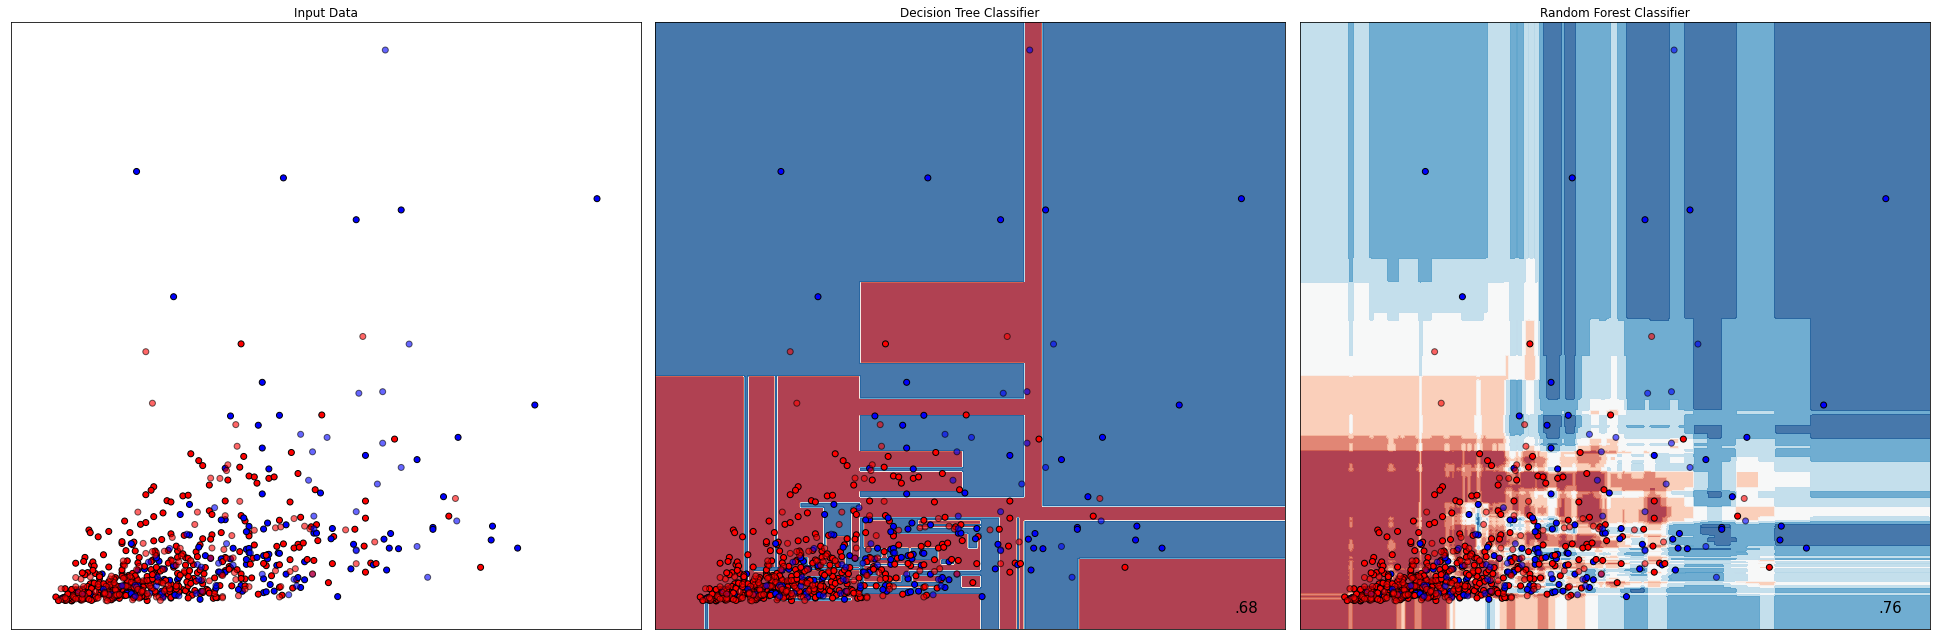

In [33]:
h = .02

names = ['Decision Tree Classifier', 'Random Forest Classifier']

classifiers = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators=20)]

X = bankloan[['debtinc', 'creddebt']]
y = bankloan['default']

linearly_separable = (X, y)

datasets = [
    linearly_separable
]

figure = plt.figure(figsize=(27,9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title('Input Data')
        
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i+=1
        
        
# itterates over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        # plot decision boundary
        if hasattr(clf, 'decision_function'):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1
        
plt.tight_layout()
plt.show()
        

> # Boosting

In [41]:
adult = pd.read_csv("adult.csv")
adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [42]:
adult.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [43]:
adult.replace('?', np.nan, inplace=True)

In [44]:
adult.isna().sum()/len(adult)*100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

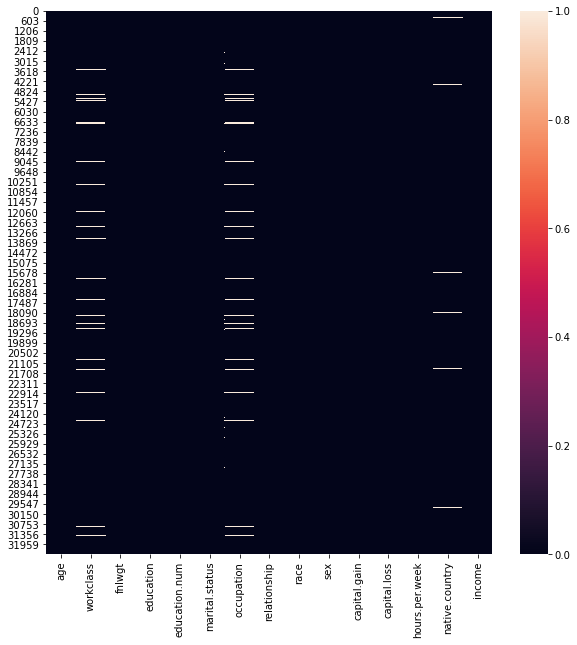

In [48]:
plt.figure(figsize=(10,10))
sns.heatmap(adult.isna())

In [50]:
adult.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


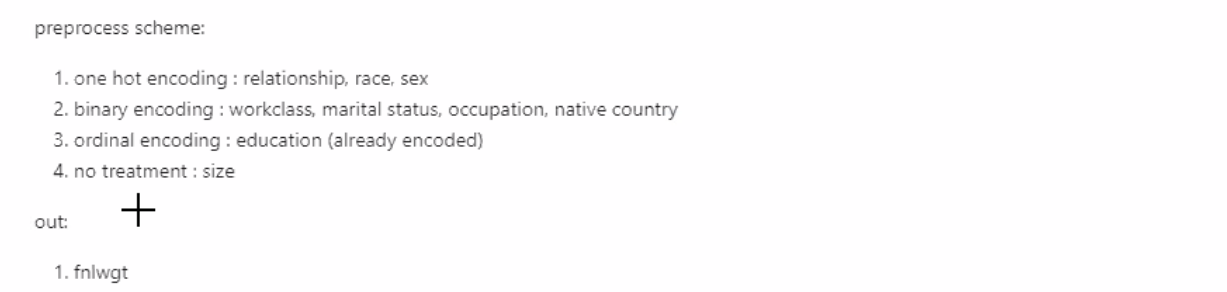

In [53]:
binary_encoder_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NC')),
    ('binary_encoder', ce.BinaryEncoder())
])


transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['sex', 'relationship', 'race']),
    ('binary', binary_encoder_pipeline, ['workclass','marital.status','occupation','native.country'])
], remainder='passthrough')



> ## Data-Splitting

In [54]:
X = adult.drop(columns=['fnlwgt','income','education'])
y = np.where(adult['income']=='>50K', 1, 0)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=10) #check random_state

In [57]:
y_train_val.shape

(24420,)

> ## Data Transformation

In [58]:
X_train_val_preprocessed = transformer.fit_transform(X_train_val)
X_test_preprocessed = transformer.transform(X_test)

/Users/ndaru/opt/anaconda3/envs/python37/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [60]:
X_train_val_preprocessed = pd.DataFrame(X_train_val_preprocessed)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)

X_train_val_preprocessed

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,63.0,9.0,0.0,0.0,40.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,47.0,13.0,0.0,0.0,40.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,90.0,4.0,0.0,0.0,40.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,64.0,9.0,7298.0,0.0,45.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.0,13.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,25.0,10.0,0.0,0.0,35.0
24416,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,51.0,15.0,3325.0,0.0,40.0
24417,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,60.0,11.0,0.0,0.0,40.0
24418,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,23.0,10.0,0.0,0.0,30.0


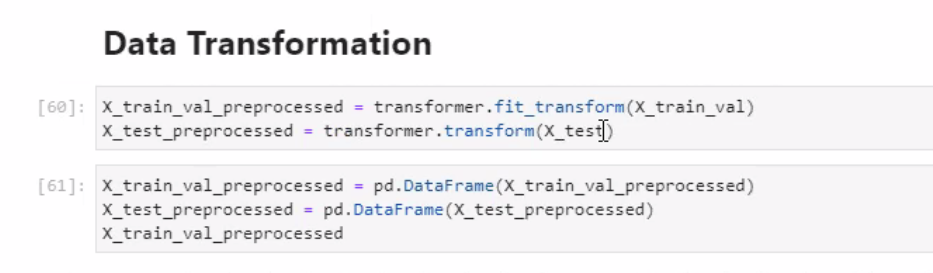

In [61]:
transformer.transformers_

[('onehot', OneHotEncoder(drop='first'), ['sex', 'relationship', 'race']),
 ('binary',
  Pipeline(steps=[('imputer',
                   SimpleImputer(fill_value='NC', strategy='constant')),
                  ('binary_encoder', BinaryEncoder())]),
  ['workclass', 'marital.status', 'occupation', 'native.country']),
 ('remainder', 'passthrough', [0, 2, 8, 9, 10])]

In [62]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_Male', 'x1_Not-in-family', 'x1_Other-relative', 'x1_Own-child',
       'x1_Unmarried', 'x1_Wife', 'x2_Asian-Pac-Islander', 'x2_Black',
       'x2_Other', 'x2_White'], dtype=object)

In [63]:
transformer.transformers_[1][1]['binary_encoder'].get_feature_names()

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6']

In [70]:
features = list(transformer.transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1]['binary_encoder'].get_feature_names() + ['age','education.num','capital.gain','capital.loss','hours.per.week']
X_train_val_preprocessed.columns = features
X_test_preprocessed.columns = features
X_train_val_preprocessed

,x0_Male,x1_Not-in-family,x1_Other-relative,x1_Own-child,x1_Unmarried,x1_Wife,x2_Asian-Pac-Islander,x2_Black,x2_Other,x2_White,...,3_2,3_3,3_4,3_5,3_6,age,education.num,capital.gain,capital.loss,hours.per.week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,63.0,9.0,0.0,0.0,40.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,47.0,13.0,0.0,0.0,40.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,90.0,4.0,0.0,0.0,40.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,64.0,9.0,7298.0,0.0,45.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.0,13.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,25.0,10.0,0.0,0.0,35.0
24416,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,51.0,15.0,3325.0,0.0,40.0
24417,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,60.0,11.0,0.0,0.0,40.0
24418,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,23.0,10.0,0.0,0.0,30.0


In [92]:
X_test_preprocessed

,x0_Male,x1_Not-in-family,x1_Other-relative,x1_Own-child,x1_Unmarried,x1_Wife,x2_Asian-Pac-Islander,x2_Black,x2_Other,x2_White,...,3_2,3_3,3_4,3_5,3_6,age,education.num,capital.gain,capital.loss,hours.per.week
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,37.0,10.0,7298.0,0.0,36.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,31.0,9.0,0.0,0.0,40.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,50.0,7.0,0.0,2444.0,40.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,34.0,9.0,0.0,0.0,48.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,32.0,9.0,0.0,1672.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,27.0,13.0,0.0,0.0,40.0
8137,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.0,10.0,0.0,0.0,36.0
8138,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,56.0,5.0,0.0,0.0,40.0
8139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,54.0,4.0,0.0,0.0,60.0


> ## Model Fitting and Evaluation : Decision Tree

In [71]:
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(X_train_val_preprocessed, y_train_val)


DecisionTreeClassifier(max_depth=3)

In [72]:
y_pred = dtc.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.53      0.59      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



In [73]:
dtc.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.29463529, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00087777, 0.25200161, 0.45248533, 0.        ,
       0.        ])

In [74]:
importance_table = pd.DataFrame({
    'imp': dtc.feature_importances_
}, index=features)

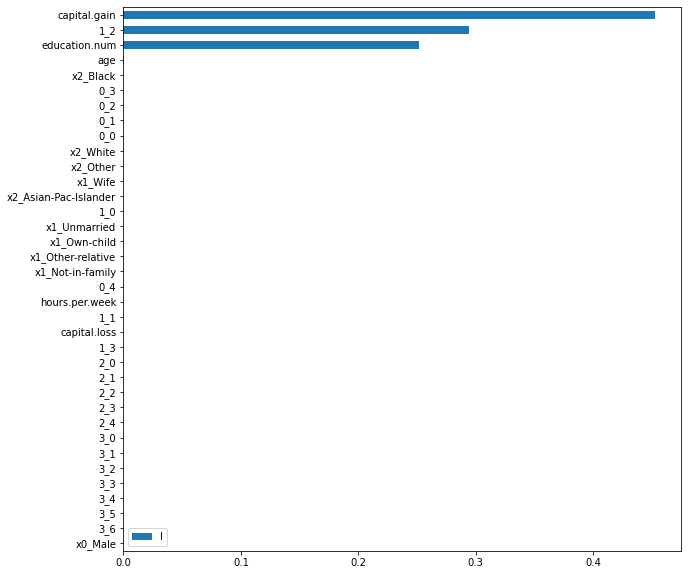

In [76]:
importance_table.sort_values(by='imp').plot(kind='barh', figsize=(10,10))
plt.legend('lower right')

[Text(167.4, 190.26, 'X[33] <= 5119.0\ngini = 0.366\nsamples = 24420\nvalue = [18539, 5881]'),
 Text(83.7, 135.9, 'X[17] <= 0.5\ngini = 0.325\nsamples = 23225\nvalue = [18479, 4746]'),
 Text(41.85, 81.53999999999999, 'X[32] <= 12.5\ngini = 0.433\nsamples = 13867\nvalue = [9481, 4386]'),
 Text(20.925, 27.180000000000007, 'gini = 0.348\nsamples = 10368\nvalue = [8040, 2328]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.484\nsamples = 3499\nvalue = [1441, 2058]'),
 Text(125.55000000000001, 81.53999999999999, 'X[32] <= 13.5\ngini = 0.074\nsamples = 9358\nvalue = [8998, 360]'),
 Text(104.625, 27.180000000000007, 'gini = 0.053\nsamples = 8904\nvalue = [8661, 243]'),
 Text(146.475, 27.180000000000007, 'gini = 0.383\nsamples = 454\nvalue = [337, 117]'),
 Text(251.10000000000002, 135.9, 'X[33] <= 7073.5\ngini = 0.095\nsamples = 1195\nvalue = [60, 1135]'),
 Text(209.25, 81.53999999999999, 'X[33] <= 5316.5\ngini = 0.454\nsamples = 132\nvalue = [46, 86]'),
 Text(188.32500000000002, 27

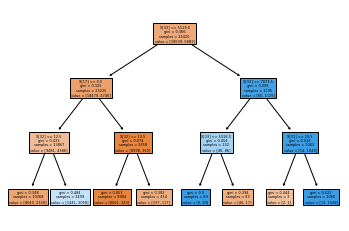

In [79]:
plot_tree(dtc, filled=True)

> ## Model Fitting and Evaluation : Adaptive Boosting

In [80]:
tree = DecisionTreeClassifier(max_depth = 3)
adaboost = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state = 10)

adaboost.fit(X_train_val_preprocessed, y_train_val)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)

In [81]:
y_pred_ada = adaboost.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.53      0.59      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



In [83]:
adaboost.base_estimator_

DecisionTreeClassifier(max_depth=3)

In [88]:
adaboost.estimators_[:10]

[DecisionTreeClassifier(max_depth=3, random_state=1165313289),
 DecisionTreeClassifier(max_depth=3, random_state=1283169405),
 DecisionTreeClassifier(max_depth=3, random_state=89128932),
 DecisionTreeClassifier(max_depth=3, random_state=2124247567),
 DecisionTreeClassifier(max_depth=3, random_state=574014784),
 DecisionTreeClassifier(max_depth=3, random_state=1902734705),
 DecisionTreeClassifier(max_depth=3, random_state=1068604539),
 DecisionTreeClassifier(max_depth=3, random_state=1425548444),
 DecisionTreeClassifier(max_depth=3, random_state=2141071321),
 DecisionTreeClassifier(max_depth=3, random_state=357864157)]

In [90]:
adaboost.estimator_errors_[:20]

array([0.17031122, 0.19432323, 0.20578292, 0.24028166, 0.28190852,
       0.28740252, 0.32699794, 0.3059536 , 0.32217397, 0.35898061,
       0.3481081 , 0.34621973, 0.35557063, 0.38342429, 0.40613579,
       0.37811749, 0.40334889, 0.39735399, 0.43311677, 0.43614828])

In [84]:
adaboost.feature_importances_

array([0.0258464 , 0.00960216, 0.009289  , 0.01457545, 0.01017442,
       0.03031946, 0.00941957, 0.01103832, 0.00498313, 0.00606006,
       0.        , 0.00086927, 0.01589043, 0.0163256 , 0.02640805,
       0.        , 0.03315566, 0.04220755, 0.01863111, 0.        ,
       0.02119745, 0.03155093, 0.01807601, 0.04351478, 0.        ,
       0.00559277, 0.0024098 , 0.00085027, 0.00817917, 0.00398978,
       0.00185325, 0.16326128, 0.10801934, 0.10437954, 0.07086513,
       0.13146486])

In [86]:
importance_table_ada = pd.DataFrame({
    'imp': adaboost.feature_importances_
}, index=features)

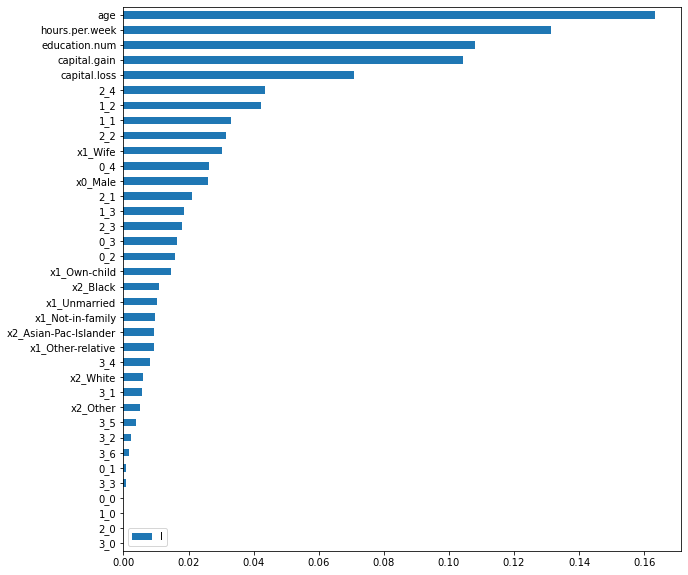

In [87]:
importance_table_ada.sort_values(by='imp').plot(kind='barh', figsize=(10,10))
plt.legend('lower right')

> ## Model Fitting and Evaluation : Gradient Boosting

In [94]:

gbc = GradientBoostingClassifier(max_depth =3 ,n_estimators = 200, learning_rate = 0.1, random_state = 10)

gbc.fit(X_train_val_preprocessed, y_train_val)

GradientBoostingClassifier(n_estimators=200, random_state=10)

In [95]:
y_pred_gb = gbc.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



In [101]:
gbc.estimators_[:5]

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FA313B04AF0)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FA313B04AF0)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FA313B04AF0)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FA313B04AF0)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FA313B04AF0)]],
      dtype=object)

In [102]:
gbc.max_features_

36

In [96]:
gbc.feature_importances_

array([9.06005038e-03, 4.85020073e-03, 2.40868918e-04, 1.21162738e-03,
       1.82262896e-03, 8.60104652e-03, 3.21263971e-04, 3.67007980e-04,
       3.25846211e-05, 5.13357663e-04, 0.00000000e+00, 0.00000000e+00,
       2.27251173e-03, 2.12079267e-03, 4.50684141e-03, 0.00000000e+00,
       8.81091756e-02, 1.83515104e-01, 1.88884551e-02, 0.00000000e+00,
       1.15819756e-02, 1.52660958e-03, 3.72708274e-03, 2.66136675e-02,
       0.00000000e+00, 6.97928446e-05, 3.40871522e-05, 2.04137308e-04,
       1.07708859e-03, 5.40624745e-04, 1.13486415e-04, 6.00090507e-02,
       1.80130619e-01, 2.81196362e-01, 6.18185251e-02, 4.49233734e-02])

In [97]:
importance_table_gb = pd.DataFrame({
    'imp': gbc.feature_importances_
}, index=features)

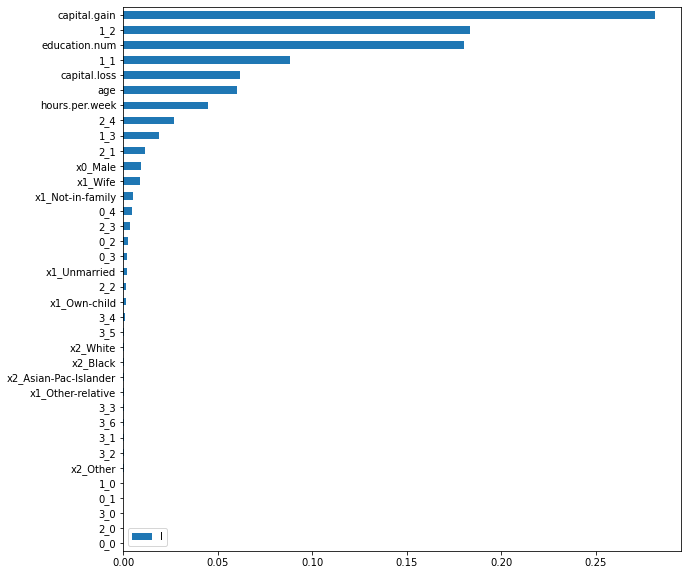

In [98]:
importance_table_gb.sort_values(by='imp').plot(kind='barh', figsize=(10,10))
plt.legend('lower right')

> ## Model Fitting and Evaluation : XGBoost

In [103]:
xgb = XGBClassifier(max_depth =3 ,n_estimators = 200, learning_rate = 0.1, random_state = 10)

xgb.fit(X_train_val_preprocessed, y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
y_pred_xgb = xgb.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



In [105]:
xgb.feature_importances_

array([0.02382891, 0.01906542, 0.00594988, 0.03239355, 0.00719362,
       0.01363541, 0.00312148, 0.003516  , 0.00272329, 0.00489323,
       0.        , 0.        , 0.00578366, 0.01630891, 0.00997159,
       0.        , 0.14776042, 0.31295022, 0.03575591, 0.        ,
       0.02868223, 0.00862654, 0.01334533, 0.06695757, 0.        ,
       0.0017172 , 0.00210135, 0.00401461, 0.00836431, 0.00453637,
       0.0028666 , 0.03242961, 0.07701948, 0.05950557, 0.02379102,
       0.02119079], dtype=float32)

In [106]:
importance_table_xgb = pd.DataFrame({
    'imp': xgb.feature_importances_
}, index=features)

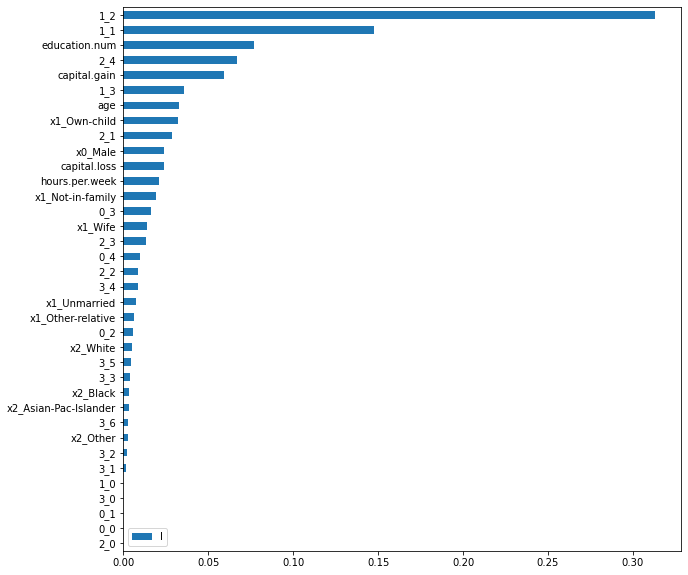

In [107]:
importance_table_xgb.sort_values(by='imp').plot(kind='barh', figsize=(10,10))
plt.legend('lower right')